In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

import seaborn as sns


### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT
DATE_TRUNC('month', creation_date) as Date,
SUM (views_count)
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY DATE_TRUNC ('month', creation_date)
ORDER BY SUM (views_count)DESC

'''

first_df = pd.read_sql_query(query, con=engine) 
first_df
# выполните запрос

,date,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

# напишите ваш ответ здесь
Данные сильно отличаются по месяцам. Видим пик активности с сентября по ноябрь. Это может быть связано с циклом обучения (летом каникулы) январь - праздники

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''

WITH temple AS 
(SELECT 
u.display_name,
p.user_id,
p.id,
pt.type,
COUNT (p.id) OVER (PARTITION BY u.display_name)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
WHERE type='Answer'
AND
p.creation_date >= DATE_TRUNC('day', u.creation_date) 
AND p.creation_date <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month')

SELECT 
display_name,
COUNT (Distinct user_id)
FROM temple
WHERE count>100
GROUP BY display_name




'''
 
# выполните запрос
two = pd.read_sql_query(query, con=engine)
two

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


# напишите ваш ответ здесь
для одного id  есть несколько имен - значит на платформе допускается неуникальность имен

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query = '''

SELECT 
DATE_TRUNC ('month',creation_date) as Month,
COUNT (id)
FROM stackoverflow.posts
WHERE user_id IN

(SELECT
u.id
FROM stackoverflow.users u
LEFT JOIN stackoverflow.posts p ON u.id=p.user_id
WHERE  u.creation_date::date >= '2008-09-01'
          AND u.creation_date::date <= '2008-09-30' 
AND
p.creation_date::date >= '2008-12-01' AND p.creation_date::date<= '2008-12-31')

GROUP BY DATE_TRUNC ('month',creation_date)
ORDER BY DATE_TRUNC ('month',creation_date) DESC

'''

# выполните запрос

table = pd.read_sql_query(query, con=engine)
table

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


# напишите ваш ответ здесь
Аномальные посты в августе могут быть следствием того, что сервис позволяет оставлять сообщения без регистрации, но присваивает идентификатор пользователя

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query = '''
SELECT

user_id,
creation_date,
views_count,
SUM(views_count) OVER (partition BY user_id ORDER BY creation_date )

FROM StackOverflow.posts
ORDER BY 1,
2
'''

# выполните запрос

four = pd.read_sql_query(query, con=engine)
four

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query = '''
WITH temp_table AS
  (SELECT user_id,
          DATE_TRUNC('day', creation_date) AS DAY,
          COUNT(DATE_TRUNC('day', creation_date)) AS posts_count
   FROM stackoverflow.posts
   WHERE creation_date::date >= '2008-08-01'
     AND creation_date::date <= '2008-08-31'
     AND user_id IN
       (SELECT user_id
        FROM stackoverflow.posts
        WHERE creation_date::date >= '2008-08-01'
          AND creation_date::date <= '2008-08-31'
        GROUP BY user_id
        HAVING COUNT(user_id) > 120)
   GROUP BY user_id,
            DAY)
SELECT user_id,
       AVG(posts_count) AS avg_daily
FROM temp_table
GROUP BY user_id
ORDER BY avg_daily; 
'''

# выполните запрос

five = pd.read_sql_query(query, con=engine)
five

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query = '''
WITH temple AS
(SELECT DISTINCT user_id,
COUNT (DISTINCT EXTRACT (DAY FROM creation_date))

FROM stackoverflow.posts


WHERE creation_date::date >= '2008-12-01'
     AND creation_date::date <= '2008-12-07'

GROUP BY  user_id

)


SELECT 
ROUND (AVG (count),0)

FROM temple
'''

# выполните запрос
six=pd.read_sql_query(query, con=engine)
six.head()

,round
0,2.0


# напишите ваш ответ здесь
Пользователи заходият на платформу 2 дня в неделю. 

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:
# напишите запрос
query = '''
WITH temple as
(SELECT 
user_id,
creation_date,
LAG (creation_date,2) OVER (Partition by user_id ORDER BY creation_date) AS lag
FROM StackOverflow.posts
ORDER BY user_id,
2)

SELECT
user_id,
creation_date,

CASE 


    WHEN EXTRACT (MONTH FROM lag ) =7 THEN 'Июль'
    WHEN EXTRACT (MONTH FROM lag ) =8 THEN 'Август'
         WHEN EXTRACT (MONTH FROM lag ) =9 THEN 'Сентябрь'
 WHEN EXTRACT (MONTH FROM lag ) =10 THEN 'Октябрь'
      WHEN EXTRACT (MONTH FROM lag ) =11 THEN 'Ноябрь'
       WHEN EXTRACT (MONTH FROM lag ) =9 THEN 'Декабрь'
       END





FROM temple

'''

# выполните запрос

seven=pd.read_sql_query(query, con=engine)
seven.head()

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,Июль
3,1,2008-08-04 02:45:08,Июль
4,1,2008-08-04 04:31:03,Июль


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
query = '''

WITH temple AS
(SELECT 
user_id,
DATE_TRUNC('month',creation_date) AS month,
MIN (DATE_TRUNC('month',creation_date)) OVER (PARTITION BY user_id) AS cohort_dt,
COUNT (user_id)
FROM StackOverflow.posts
GROUP BY 1,
2),

temple2 AS
(SELECT 
DISTINCT user_id as user_id,
cohort_dt
FROM temple),

profile AS
(SELECT 
user_id,
cohort_dt,
COUNT(*) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
FROM temple2),

sessions AS
(SELECT
user_id,
DATE_TRUNC('month',creation_date) AS month_post
FROM StackOverflow.posts
GROUP BY 1,
2)

SELECT 
 
p.cohort_dt,
month_post,
COUNT(p.user_id) AS users_cnt,
cohort_users_cnt,
ROUND (COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p JOIN sessions s ON p.user_id=s.user_id
GROUP BY 1,
         2,
         4



 

 


'''

# выполните запрос

eight=pd.read_sql_query(query, con=engine)
eight.head(30)

,cohort_dt,month_post,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

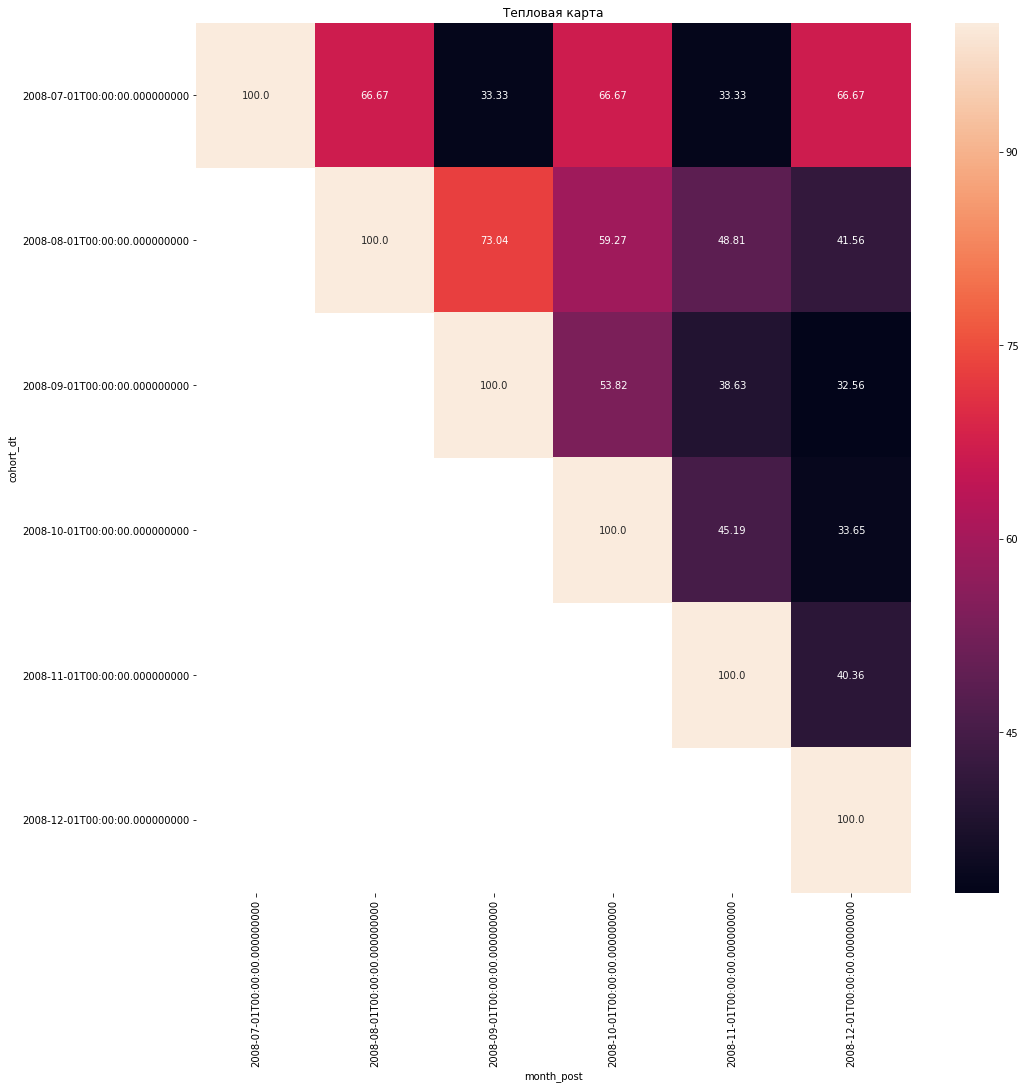

In [14]:
# постройте тепловую карту Retention Rate


pivot=eight.pivot_table(
index='cohort_dt',
columns='month_post',
values='retention_rate',
aggfunc='mean')


plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(pivot, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика

plt.show() 


# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [15]:
# напишите запрос
query = '''
WITH temple AS

(SELECT
EXTRACT (month FROM creation_date ) as creation_date,
COUNT (id)
FROM StackOverflow.posts
 
 WHERE creation_date >= '2008-09-01'
          AND creation_date <= '2008-12-31'
GROUP BY EXTRACT (month FROM creation_date ))

SELECT 
creation_date,
count,
ROUND ((CAST (count AS numeric) /LAG (count) OVER ( ) -1) *100,2)
FROM temple

'''

# выполните запрос

nine=pd.read_sql_query(query, con=engine)
nine.head()

,creation_date,count,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

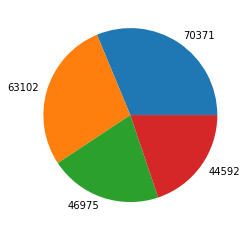

In [16]:
# постройте круговую диаграмму с количеством постов по месяцам

fig1, ax1 = plt.subplots()
ax1.pie(nine['count'], labels=nine['count'])
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
# напишите запрос
query = '''

WITH 
 
temple AS
(SELECT 
user_id,
creation_date,
EXTRACT (week FROM creation_date::date) as week

FROM StackOverflow.posts

WHERE user_id IN
    (SELECT user_id FROM stackoverflow.posts GROUP BY user_id ORDER BY COUNT(user_id) DESC LIMIT 1)



AND creation_date::date >= '2008-10-01'
          AND creation_date::date <= '2008-10-31'
ORDER BY EXTRACT (week FROM creation_date),
creation_date)
 
 
SELECT 
DISTINCT week,
MAX (creation_date) OVER (PARTITION BY week)
FROM temple
ORDER BY MAX (creation_date) OVER (PARTITION BY week)

'''

# выполните запрос

ten=pd.read_sql_query(query, con=engine)
ten.head(20)

,week,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
